In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model, Input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

## Load in the Validation and Test Set

In [2]:
X_val = np.load("256_192_val.npy")

In [3]:
X_test = np.load("256_192_test.npy")

In [4]:
y_val = np.load("val_labels.npy")

In [5]:
y_test = np.load("test_labels.npy")

In [6]:
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [7]:
X_val.shape, X_test.shape, y_val.shape, y_test.shape

((902, 192, 256, 3), (1002, 192, 256, 3), (902, 7), (1002, 7))

In [8]:
input_shape = X_val[0,:,:,:].shape
model_input = Input(shape=input_shape)

In [9]:
X_val_224 = np.load("224_224_val.npy")
X_test_224 = np.load("224_224_test.npy")
y_val_224 = np.load("val_labels_224.npy")
y_test_224 = np.load("test_labels_224.npy")
y_val_224 = to_categorical(y_val_224)
y_test_224 = to_categorical(y_test_224)
input_shape_224 = X_val_224[0,:,:,:].shape
model_input_224 = Input(shape=input_shape_224)

## Define InceptionV3

In [10]:
inception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [11]:
for layer in inception.layers:
    layer.trainable = True

In [12]:
inception_last_layer = inception.get_layer('mixed10')
print('last layer output shape:', inception_last_layer.output_shape)
inception_last_output = inception_last_layer.output

last layer output shape: (None, 4, 6, 2048)


In [13]:
# Flatten the output layer to 1 dimension
x_inception = layers.GlobalMaxPooling2D()(inception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_inception = layers.Dense(512, activation='relu')(x_inception)
# Add a dropout rate of 0.7
x_inception = layers.Dropout(0.5)(x_inception)
# Add a final sigmoid layer for classification
x_inception = layers.Dense(7, activation='softmax')(x_inception)

# Configure and compile the model

inception_model = Model(model_input, x_inception)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
inception_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\chara_eoccfea\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
inception_model.load_weights("InceptionV3.h5")

In [15]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 127, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 127, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Define DenseNet 201 

In [16]:
denseNet = DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [17]:
for layer in denseNet.layers:
    layer.trainable = True

In [18]:
denseNet_last_layer = denseNet.get_layer('relu')
print('last layer output shape:', denseNet_last_layer.output_shape)
denseNet_last_output = denseNet_last_layer.output

last layer output shape: (None, 6, 8, 1920)


In [19]:
# Flatten the output layer to 1 dimension
x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
x_denseNet = layers.Dropout(0.5)(x_denseNet)
# Add a final sigmoid layer for classification
x_denseNet = layers.Dense(7, activation='softmax')(x_denseNet)

# Configure and compile the model

denseNet_model = Model(model_input, x_denseNet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
denseNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [20]:
denseNet_model.load_weights("DenseNet.h5")

In [21]:
denseNet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 96, 128, 64)  9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 96, 128, 64)  256         ['conv1/conv[0][0]']       

Define MobileNetV2 Model

In [22]:
mobilenet = MobileNetV2(input_shape=input_shape_224, input_tensor=model_input_224, include_top=False, weights=None)

In [23]:
for layer in mobilenet.layers:
    layer.trainable = True

In [24]:
mobileNet_last_layer = mobilenet.get_layer('out_relu')
print('last layer output shape:', mobileNet_last_layer.output_shape)
mobileNet_last_output = mobileNet_last_layer.output

last layer output shape: (None, 7, 7, 1280)


In [25]:
mobileNet_last_outputlast_output=mobilenet.layers[-6].output
# Flatten the output layer to 1 dimension
x_mobile = layers.GlobalMaxPooling2D()(mobileNet_last_output)
# Add a fully connected layer with 10 hidden units and ReLU activation
x_mobile = layers.Dense(1024, activation='relu')(x_mobile)
# Add a dropout rate of 0.7
x_mobile = layers.Dropout(0.3)(x_mobile)
# Add a final sigmoid layer for classification
x_mobile = layers.Dense(7, activation='softmax')(x_mobile)

# Configure and compile the model

mobileNet_model = Model(model_input_224, x_mobile)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
mobileNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [26]:
mobileNet_model.load_weights("MobileNetV2.h5")

In [27]:
mobileNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

Define ResNet50 Model

In [28]:
resnet = ResNet50(input_shape=input_shape_224, input_tensor=model_input_224, include_top=False, weights=None)

In [29]:
for layer in resnet.layers:
    layer.trainable = True

In [30]:
resNet_last_layer = resnet.get_layer('conv5_block3_out')
print('last layer output shape:', resNet_last_layer.output_shape)
resNet_last_output = resNet_last_layer.output

last layer output shape: (None, 7, 7, 2048)


In [31]:
# Flatten the output layer to 1 dimension
x_resnet = layers.GlobalMaxPooling2D()(resNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x_resnet = layers.Dense(2048, activation='relu')(x_resnet)
# Add a dropout rate of 0.7
x_resnet = layers.Dropout(0.5)(x_resnet)
# Add a final sigmoid layer for classification
x_resnet = layers.Dense(7, activation='softmax')(x_resnet)

# Configure and compile the model

resNet_model = Model(model_input_224, x_resnet)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
resNet_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [32]:
resNet_model.load_weights("ResNet50.h5")

In [33]:
resNet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Define Ensemble Model

In [34]:
from keras.layers import Input, concatenate, GlobalAveragePooling2D
def feature_level_ensemble(models_224, models_default, input_shape_224, input_shape_default):
    # Create separate inputs for each input size
    model_input_224 = Input(shape=input_shape_224)
    model_input_default = Input(shape=input_shape_default)

    # Apply GlobalAveragePooling2D to each model's output
    outputs_224 = [GlobalAveragePooling2D()(model(model_input_224)) for model in models_224]
    outputs_default = [GlobalAveragePooling2D()(model(model_input_default)) for model in models_default]

    # Concatenate all outputs
    merged = concatenate(outputs_224 + outputs_default, axis=-1)

    # Additional layers can be added here if needed
    merged = layers.Dense(512, activation='relu')(merged)
    merged = layers.Dropout(0.5)(merged)
    predictions = layers.Dense(7, activation='softmax')(merged)

    # Create a new model that takes the two inputs and outputs the combined features
    model = Model(inputs=[model_input_224, model_input_default], outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models_default = [denseNet, inception]
models_224 = [resnet, mobilenet]

# Define the input shapes for each group of models
input_shape_default = (192,256, 3) 
input_shape_224 = (224, 224, 3)

In [35]:
# Create the ensemble model
ensemble_model = feature_level_ensemble(models_224, models_default, input_shape_224, input_shape_default)

In [36]:
ensemble_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

## Testing

In [37]:
# Evaluate the ensemble model
loss_val, acc_val = ensemble_model.evaluate([X_val_224, X_val], y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (acc_val, loss_val))


29/29 [==============================] - 18s 281ms/step - loss: 0.0376 - accuracy: 0.0.98463
Validation: accuracy = 0.9846  ;  loss_v = 0.367646


In [40]:
loss_test, acc_test = ensemble_model.evaluate([X_test_224, X_test], y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

Test: accuracy = 0.971538 ;  loss_v = 0.0814


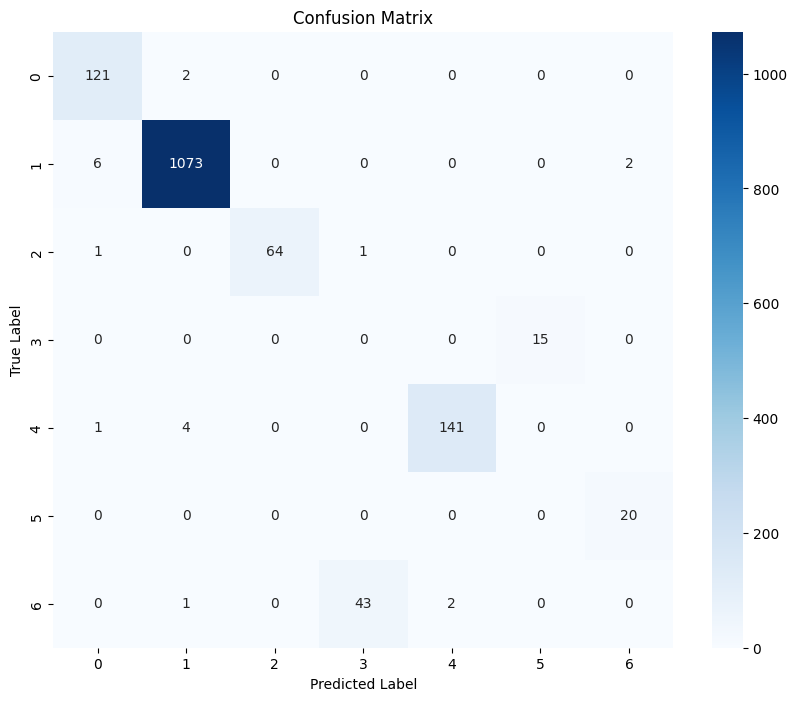

       precision  recall  f1-score  support
AKIEC       0.97    0.97      0.97      146
BCC         0.98    0.98      0.98       46
BKL         0.99    0.99      0.99     1081
DF          1.00    1.00      1.00       20
NV          0.94    0.98      0.96      123
MEL         1.00    0.97      0.98       66
VASC        1.00    1.00      1.00       15


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = ensemble_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1) 

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


### Inferences

NV: Melanocytic nevi
BKL: Benign keratosis-like lesions
MEL: Melanoma
BCC: Basal cell carcinoma
AKIEC: Actinic keratoses and intraepithelial carcinoma
VASC: Vascular lesions


The model is very accurate in predicting Melanocytic nevi (NV) and Basal cell carcinoma (BCC) with very high precision and recall, which suggests it is well-trained to identify these common lesions.

Melanoma (MEL) classification also has high precision and recall, which is particularly important given that melanoma is the most dangerous form of skin cancer. 

The perfect scores for Vascular lesions (VASC) might be due to distinct features that are easier for the model to learn, as the dataset contains a limited variety of images for this class.

Actinic keratoses (AKIEC) have a high precision but slightly lower recall. This suggests the model is conservative in predicting this class, possibly to avoid false positives, which might be acceptable given that actinic keratoses can sometimes progress to squamous cell carcinoma.

The 'support' column indicates the number of samples for each class in the test set. The relatively lower support for some classes (like VASC) means the model's performance metrics for these classes are based on a smaller sample size and thus might not be as reliable as metrics for classes with larger support.

Benign keratosis-like lesions (BKL) have good precision and recall, indicating the model's effectiveness in differentiating these from malignant lesions, which is crucial to reduce unnecessary biopsies.